
The purpose of this notebook is to determine the readability or unreadability of code generated by LLM using another LLM as a Judge / Evaluator.

## Install Dependencies and Import Libraries

In [8]:
!pip install -qq "arize-phoenix-evals>=0.0.5" "openai>=1" ipython matplotlib pycm scikit-learn tiktoken nest_asyncio 'httpx<0.28'
!pip install mistralai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.5/262.5 kB 12.1 MB/s eta 0:00:00


In [14]:
N_EVAL_SAMPLE_SIZE = 10

ℹ️ To enable async request submission in notebook environments like Jupyter or Google Colab, optionally use `nest_asyncio`. `nest_asyncio` globally patches `asyncio` to enable event loops to be re-entrant. This is not required for non-notebook environments.

Without `nest_asyncio`, eval submission can be much slower, depending on your organization's rate limits. Speed increases of about 5x are typical.

In [ ]:
import nest_asyncio

nest_asyncio.apply()

In [6]:
import os
from getpass import getpass

import matplotlib.pyplot as plt
import openai
import pandas as pd
from pycm import ConfusionMatrix
from sklearn.metrics import classification_report

from phoenix.evals import (
    CODE_READABILITY_PROMPT_RAILS_MAP,
    CODE_READABILITY_PROMPT_TEMPLATE,
    OpenAIModel,
    MistralAIModel,
    download_benchmark_dataset,
    llm_classify,
)

pd.set_option("display.max_colwidth", None)

## Download Benchmark Dataset

We'll evaluate the system consisting of an LLM model which was used to generate implementation code, using an evaluation prompt template against a benchmark dataset of readable and unreadable code with ground-truth labels. For this task we look at the following dataset:

- openai_humaneval_with_readability

In [12]:
dataset_name = "openai_humaneval_with_readability"
df = download_benchmark_dataset(task="code-readability-classification", dataset_name=dataset_name)
df.head()

,Unnamed: 0,task_id,prompt,canonical_solution,test,entry_point,readable,solution
0,0,HumanEval/0,"from typing import List\n\n\ndef has_close_elements(numbers: List[float], threshold: float) -> bool:\n """""" Check if in given list of numbers, are any two numbers closer to each other than\n given threshold.\n >>> has_close_elements([1.0, 2.0, 3.0], 0.5)\n False\n >>> has_close_elements([1.0, 2.8, 3.0, 4.0, 5.0, 2.0], 0.3)\n True\n """"""\n","for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n","\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.3) == True\n assert candidate([1.0, 2.0, 3.9, 4.0, 5.0, 2.2], 0.05) == False\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.95) == True\n assert candidate([1.0, 2.0, 5.9, 4.0, 5.0], 0.8) == False\n assert candidate([1.0, 2.0, 3.0, 4.0, 5.0, 2.0], 0.1) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 1.0) == True\n assert candidate([1.1, 2.2, 3.1, 4.1, 5.1], 0.5) == False\n\n",has_close_elements,True,"for idx, elem in enumerate(numbers):\n for idx2, elem2 in enumerate(numbers):\n if idx != idx2:\n distance = abs(elem - elem2)\n if distance < threshold:\n return True\n\n return False\n"
1,1,HumanEval/1,"from typing import List\n\n\ndef separate_paren_groups(paren_string: str) -> List[str]:\n """""" Input to this function is a string containing multiple groups of nested parentheses. Your goal is to\n separate those group into separate strings and return the list of those.\n Separate groups are balanced (each open brace is properly closed) and not nested within each other\n Ignore any spaces in the input string.\n >>> separate_paren_groups('( ) (( )) (( )( ))')\n ['()', '(())', '(()())']\n """"""\n",result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate('(()()) ((())) () ((())()())') == [\n '(()())', '((()))', '()', '((())()())'\n ]\n assert candidate('() (()) ((())) (((())))') == [\n '()', '(())', '((()))', '(((())))'\n ]\n assert candidate('(()(())((())))') == [\n '(()(())((())))'\n ]\n assert candidate('( ) (( )) (( )( ))') == ['()', '(())', '(()())']\n",separate_paren_groups,True,result = []\n current_string = []\n current_depth = 0\n\n for c in paren_string:\n if c == '(':\n current_depth += 1\n current_string.append(c)\n elif c == ')':\n current_depth -= 1\n current_string.append(c)\n\n if current_depth == 0:\n result.append(''.join(current_string))\n current_string.clear()\n\n return result\n
2,2,HumanEval/2,"\n\ndef truncate_number(number: float) -> float:\n """""" Given a positive floating point number, it can be decomposed into\n and integer part (largest integer smaller than given number) and decimals\n (leftover part always smaller than 1).\n\n Return the decimal part of the number.\n >>> truncate_number(3.5)\n 0.5\n """"""\n",return number % 1.0\n,"\n\nMETADATA = {\n 'author': 'jt',\n 'dataset': 'test'\n}\n\n\ndef check(candidate):\n assert candidate(3.5) == 0.5\n assert abs(candidate(1.33) - 0.33) < 1e-6\n assert abs(candidate(123.456) - 0.456) < 1e-6\n",truncate_number,False,return((lambda x: (lambda y: y(x))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u)))))(lambda f: (lambda x: f(lambda v: x(x)(v)))(lambda y: f(lambda u: y(y)(u))))(lambda f: lambda x: x if x == 0 else f(x - 1) + 1)(number % 1.0))
3,3,HumanEval/3,"from typing import List\n\n\ndef below_zero(operations: List[int]) -> bool:\n """""" You're given a list of deposit and withdrawal operations on a ban

Binary Readability Classification Template


In [3]:
print(CODE_READABILITY_PROMPT_TEMPLATE)


You are a stern but practical senior software engineer who cares a lot about simplicity and
readability of code. Can you review the following code that was written by another engineer?
Focus on readability of the code. Respond with "readable" if you think the code is readable,
or "unreadable" if the code is unreadable or needlessly complex for what it's trying
to accomplish.

ONLY respond with "readable" or "unreadable"

Task Assignment:
```
{input}
```

Implementation to Evaluate:
```
{output}
```



The template variables are:

- **input:** the query from the user describing the coding task
- **output:** an implementation of the coding task

## Configure the  LLM Judge / Evaluator

Configure your MISTRALAI API key.

In [4]:
if not (mistralai_api_key := os.getenv("MISTRALAI_API_KEY")):
    mistralai_api_key = getpass("🔑 Enter your MISTRALAI API key: ")
os.environ["MISTRALAI_API_KEY"] = mistralai_api_key

🔑 Enter your MISTRALAI API key: ··········


Instantiate the LLM Judge / Evaluator and set parameters.


In [9]:
model = MistralAIModel(
    model="codestral-mamba-2407",
    temperature=0.0,
    api_key=mistralai_api_key,
)

Simple test that we are able call the model

In [10]:
model("Hello, are you ready to classify a code as readable or not?")

"Hello! I'm here to help you with your question. However, I need more information to provide a meaningful response. Could you please provide the code you want to classify as readable or not? Additionally, it would be helpful if you could specify the programming language of the code."

## Sample Benchmark Dataset
Sample size determines run time

In [15]:
df = df.sample(n=N_EVAL_SAMPLE_SIZE).reset_index(drop=True)
df = df.rename(
    columns={"prompt": "input", "solution": "output"},
)



## LLM Code Readability Classifications

Run readability classifications against a subset of the data.

In [ ]:
# The rails is used to hold the output to specific values based on the template
# It will remove text such as ",,," or "..."
# Will ensure the binary value expected from the template is returned
rails = list(CODE_READABILITY_PROMPT_RAILS_MAP.values())
readability_classifications = llm_classify(
    dataframe=df,
    template=CODE_READABILITY_PROMPT_TEMPLATE,
    model=model,
    rails=rails,
    concurrency=None,
    verbose=True,
    provide_explanation=True,
    max_retries=20,
    run_sync=False,
)["label"].tolist()

<ipython-input-17-37a66322dcbf>:5: DeprecationWarning: `dataframe` argument is deprecated; use `data` instead
  readability_classifications = llm_classify(


llm_classify |          | 0/10 (0.0%) | ⏳ 00:00<? | ?it/s

Exception in worker on attempt 1: API error occurred: Status 429
{"message":"Requests rate limit exceeded"}
Retrying...
Exception in worker on attempt 1: API error occurred: Status 429
{"message":"Requests rate limit exceeded"}
Retrying...
Exception in worker on attempt 2: API error occurred: Status 429
{"message":"Requests rate limit exceeded"}
Retrying...
Exception in worker on attempt 3: API error occurred: Status 429
{"message":"Requests rate limit exceeded"}
Retrying...
Exception in worker on attempt 4: API error occurred: Status 429
{"message":"Requests rate limit exceeded"}
Retrying...
Process was interrupted. The return value will be incomplete...
Process was interrupted. The return value will be incomplete...



Evaluate the predictions against human-labeled ground-truth readability labels.

              precision    recall  f1-score   support

    readable       0.83      0.83      0.83         6
  unreadable       0.75      0.75      0.75         4

    accuracy                           0.80        10
   macro avg       0.79      0.79      0.79        10
weighted avg       0.80      0.80      0.80        10



<Axes: title={'center': 'Confusion Matrix (Normalized)'}, xlabel='Predicted Classes', ylabel='Actual Classes'>

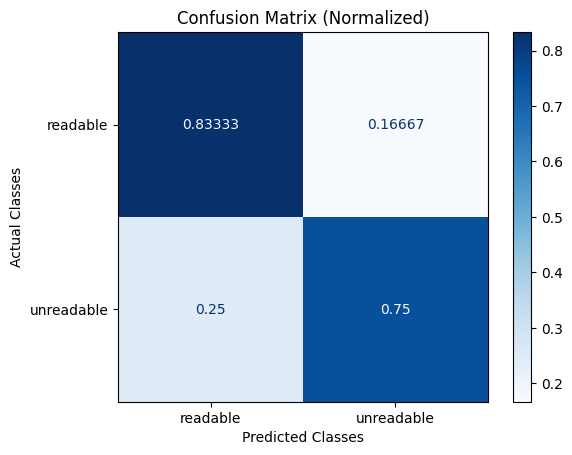

In [ ]:
true_labels = df["readable"].map(CODE_READABILITY_PROMPT_RAILS_MAP).tolist()

print(classification_report(true_labels, readability_classifications, labels=rails))
confusion_matrix = ConfusionMatrix(
    actual_vector=true_labels, predict_vector=readability_classifications, classes=rails
)
confusion_matrix.plot(
    cmap=plt.colormaps["Blues"],
    number_label=True,
    normalized=True,
)

## Inspecting evaluations

Because the evals are binary classifications, we can easily sample a few rows
where the evals deviated from ground truth and see what the actual code was in
that case.

In [ ]:
df["readability"] = readability_classifications
# inspect instances where ground truth was readable but evaluated to unreadable by the LLM
filtered_df = df.query('readable == False and readability == "readable"')

# inspect first 5 rows that meet this condition
result = filtered_df.head(5)
result

,Unnamed: 0,task_id,input,canonical_solution,test,entry_point,readable,output,readability
0,79,HumanEval/79,"\ndef decimal_to_binary(decimal):\n """"""You will be given a number in decimal form and your task is to convert it to\n binary format. The function should return a string, with each character representing a binary\n number. Each character in the string will be '0' or '1'.\n\n There will be an extra couple of characters 'db' at the beginning and at the end of the string.\n The extra characters are there to help with the format.\n\n Examples:\n decimal_to_binary(15) # returns ""db1111db""\n decimal_to_binary(32) # returns ""db100000db""\n """"""\n","return ""db"" + bin(decimal)[2:] + ""db""\n","def check(candidate):\n\n # Check some simple cases\n assert candidate(0) == ""db0db""\n assert candidate(32) == ""db100000db""\n assert candidate(103) == ""db1100111db""\n assert candidate(15) == ""db1111db"", ""This prints if this assert fails 1 (good for debugging!)""\n\n # Check some edge cases that are easy to work out by hand.\n assert True, ""This prints if this assert fails 2 (also good for debugging!)""\n\n",decimal_to_binary,False,"def obscure_code(decimal):\n binary = bin(decimal)\n binary = binary[2:]\n prefix = ""db""\n suffix = ""db""\n result = prefix + binary + suffix\n return result\n\nprint(obscure_code(10))",readable


## Classifications with explanations

When evaluating a dataset for readability, it can be useful to know why the LLM classified text as readable or not. The following code block runs `llm_classify` with explanations turned on so that we can inspect why the LLM made the classification it did. There is speed tradeoff since more tokens is being generated but it can be highly informative when troubleshooting.